In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"denisegorov","key":"ec36751b6b2a254da4471aad1bef3be2"}'}

In [2]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Jul 19 09:53 kaggle.json


In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list -s twitter-sentiment-analysis-hatred-speech

ref                                                      title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arkhoshghalb/twitter-sentiment-analysis-hatred-speech    Twitter Sentiment Analysis                           2MB  2019-01-06 05:00:19          25526        253  0.64705884       
dasikag/parler-dataset                                   Parler archived dataset 2021                       657MB  2021-01-10 22:50:25            154         12  0.9375           
mariajmraidy/datasets-for-sentiment-analysis-of-arabizi  Datasets for sentiment analysis of arabizi tweets  198KB  2020-06-23 16:40:49            332          6  0.7352941        


In [7]:
! kaggle datasets download arkhoshghalb/twitter-sentiment-analysis-hatred-speech

  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 82.5MB/s]


In [8]:
! mkdir dataset

In [9]:
! unzip twitter-sentiment-analysis-hatred-speech.zip -d dataset

Archive:  twitter-sentiment-analysis-hatred-speech.zip
  inflating: dataset/test.csv        
  inflating: dataset/train.csv       


In [10]:
! rm -R twitter-sentiment-analysis-hatred-speech.zip

In [1]:
import os
import torch
from torch import nn
import pandas as pd
import numpy as np
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import re
from torch.utils.data import DataLoader, Dataset

In [2]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [40]:
max_words = 500
max_len = 10
num_classes = 1

# Training
epochs = 5
batch_size = 512
print_batch_n = 100

In [4]:


df_train = pd.read_csv("/content/dataset/train.csv")
df_test = pd.read_csv("/content/dataset/test.csv")

In [5]:
df_val = df_train[25000:]
df_train = df_train[:25000]

In [6]:
df_train.tail(3)

,id,label,tweet
24997,24998,0,go have a listen to my new song being released...
24998,24999,0,bad day. all my 'friends' were being very mean...
24999,25000,0,what's happened to #haverfordwest. the town re...


label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist

In [7]:
df_test.head(3)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...


In [8]:

#from pymorphy2 import MorphAnalyzer


In [9]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [11]:
stopwords.add('user')

In [12]:
exclude = set(punctuation)

In [13]:
exclude

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [14]:
def clean_text(text):
  txt = str(text)
  txt = "".join(c for c in txt if c not in exclude)
  txt = " ".join(i for i in txt.split() if i not in stopwords)
  txt = txt.lower()
  return txt

In [15]:
df_train['tweet'] = df_train['tweet'].apply(clean_text)
df_test['tweet'] = df_test['tweet'].apply(clean_text)

In [16]:
df_train.head(3)

,id,label,tweet
0,1,0,father dysfunctional selfish drags kids dysfun...
1,2,0,thanks lyft credit cant use cause dont offer w...
2,3,0,bihday majesty


In [17]:

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
len(df_train)

25000

In [19]:
train_corpus = " ".join(df_train["tweet"][:25000]) #остальное для валидации

In [20]:
tokens = word_tokenize(train_corpus)

In [21]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [22]:
len(tokens_filtered)

193754

In [23]:

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [24]:
len(tokens_filtered_top)

499

In [25]:
tokens_filtered_top[:10]

['love', 'day', 'happy', 'amp', 'u', 'im', 'time', 'life', 'like', 'today']

In [26]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [27]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [28]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]], dtype=np.int32)

In [29]:
x_train[0]

array([  0,   0,   0,   0,   0,   0,   0, 166, 160, 369], dtype=int32)

In [30]:
x_train.shape

(25000, 10)

In [31]:
x_val.shape

(6962, 10)

In [32]:
x_test.shape

(17197, 10)

In [44]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)

    def forward(self, x):
        output = self.embedding(x) # B, L, E
        #                       B  E  L
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)


        return nn.functional.sigmoid(output)

In [34]:
class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [45]:
model = Net(vocab_size=1000)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(1000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 218497


In [46]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

In [47]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [49]:
def train_model(model, train_loader, val_loader):
  train_history = []
  test_history = []
  model.train()
  for epoch in range(1, epochs + 1):
    model.train()
    running_items, running_right = 0.0, 0.0

    for i, (input, target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = model(input)
      loss = criterion(output, target.float().view(-1, 1))
      #loss.requires_grad = True
      loss.backward()
      optimizer.step()

      loss = loss.item()
      running_items += len(target)
      pred_labels = torch.squeeze((output > 0.5).int())
      running_right += (target == pred_labels).sum()

    model.eval()
    print(f'Epoch [{epoch}/{epochs}] '\
          f'step [{i + 1}/{len(train_loader)}] '\
          f'Loss {loss:.3f} '\
          f'Acc {running_right / running_items:.3f}', end='. ')

    with torch.no_grad():
      running_loss, running_items, running_right,  = 0.0, 0.0, 0.0
      train_history.append(loss)

      test_loss, test_running_total, test_running_right,  = 0.0, 0.0, 0.0
      for j, (test_input, test_label) in enumerate(val_loader):
        test_output = model(test_input)
        test_loss = criterion(test_output, test_label.float().view(-1, 1))
        test_running_total += len(test_label)
        test_pred_labels = torch.squeeze((test_output > 0.5).int())
        test_running_right += (test_label == test_pred_labels).sum()

    test_history.append(test_loss.item())
    print(f'Test_loss {loss:.3f} '\
          f'Test_acc {test_running_right / test_running_total:.3f}')




  return train_history, test_history

In [50]:
train_history, test_history = train_model(model, train_loader, val_loader)

Epoch [1/5] step [49/49] Loss 0.700 Acc 0.930. Test_loss 0.700 Test_acc 0.930
Epoch [2/5] step [49/49] Loss 0.699 Acc 0.930. Test_loss 0.699 Test_acc 0.930
Epoch [3/5] step [49/49] Loss 0.697 Acc 0.930. Test_loss 0.697 Test_acc 0.930
Epoch [4/5] step [49/49] Loss 0.697 Acc 0.930. Test_loss 0.697 Test_acc 0.930
Epoch [5/5] step [49/49] Loss 0.696 Acc 0.930. Test_loss 0.696 Test_acc 0.930


лосс падает, обучение идет

In [52]:
import matplotlib.pyplot as plt


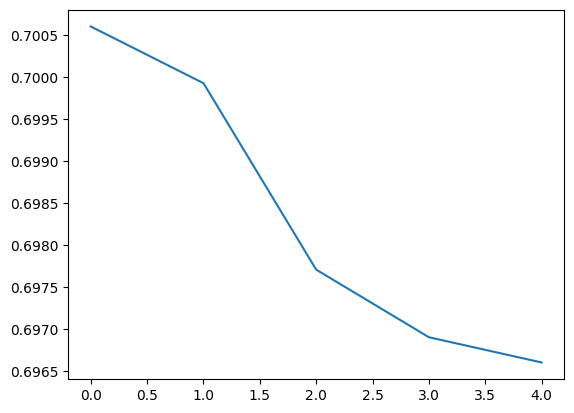

In [54]:
plt.plot(test_history)

Ни глубина словаря, ни количество слов не повлияли на точность модели, с первой эпохи обучения accuracy одинаковая. Меняет точность только архитектура модели, хотя это странно, может я где-то заплутал